# Imports

In [1]:
# Numpy, Scipy, Matplotlib
import scipy.interpolate
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

# Drake imports
from pydrake.all import RollPitchYaw, Meshcat, Quaternion, RollPitchYaw

# Other imports
import warnings

# Imports of other project files
import constants
import config

import plant.simulation
import plant.manipulator as manipulator

In [2]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Meshcat init

In [3]:
meshcat = Meshcat()
web_url = meshcat.web_url()

[2022-05-10 21:33:37.126] [console] [info] Meshcat listening for connections at http://localhost:7002


# Simulation setup

In [4]:
ctrl_paradigm = plant.simulation.CtrlParadigm.IMPEDANCE
impedance_type = plant.simulation.ImpedanceType.OFFLINE_TRAJ
n_hat_force_compensation_source = plant.simulation.NHatForceCompensationSource.NONE

In [5]:
sim_params = constants.nominal_sys_consts(num_links=config.NumLinks.TWO)
sim_params.m_L = 0.441/2
max_torque = 0.55*constants.Nm__PER_InLb
sim_params.k_J = 6*max_torque/np.pi
sim_params.b_J = sim_params.k_J/10

sim = plant.simulation.Simulation(
    sim_params=sim_params,
    DT=0.0001, num_links=config.NumLinks.TWO, TSPAN=50,
    ctrl_paradigm=ctrl_paradigm,
    impedance_type=impedance_type,
    n_hat_force_compensation_source=n_hat_force_compensation_source,
    meshcat=meshcat,
    exit_when_folded=True,
    impedance_stiffness=[4,4,4,40,40,40],
    impedance_scale=10,
    const_ff_Fn=0,
    model_impedance_delay=True,
    use_true_hinge_diameter=True
)

# Run simulation

In [6]:
t_start_ = time.time()
log = sim.run_sim()
print(time.time() - t_start_)

[CtrlSelector] Switching to contact ctrl at 1.00
Successful run!
608.5838091373444


In [7]:
def T(vec):
    return np.transpose(vec, [0, 2, 1])

In [8]:
idx = sim.log_wrapper.get_idx("pos", "trn", sim.contact_body_idx)
length = 3
p_M = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [9]:
def process_poses(poses):
    xs = []
    ys = []
    zs = []
    theta_xs = []
    theta_ys = []
    theta_zs = []
    q_ws = []
    q_xs = []
    q_ys = []
    q_zs = []
    
    for pose in poses:
        xs.append(pose["position"][0])
        ys.append(pose["position"][1])
        zs.append(pose["position"][2])

        quat_vec = np.array([
            pose['orientation'].w,
            pose['orientation'].x,
            pose['orientation'].y,
            pose['orientation'].z
        ])

        q_ws.append(quat_vec[0])
        q_xs.append(quat_vec[1])
        q_ys.append(quat_vec[2])
        q_zs.append(quat_vec[3])
        
        quat = Quaternion(
            w=pose['orientation'].w,
            x=pose['orientation'].x,
            y=pose['orientation'].y,
            z=pose['orientation'].z,
        )
        rpy = RollPitchYaw(quat).vector()
        theta_xs.append(rpy[0])
        theta_ys.append(rpy[1])
        theta_zs.append(rpy[2])
    return {
        'x': np.array(xs),
        'y': np.array(ys),
        'z': np.array(zs),
        'theta_x': np.array(theta_xs),
        'theta_y': np.array(theta_ys),
        'theta_z': np.array(theta_zs),
        'q_w': np.array(q_ws), 
        'q_x': np.array(q_xs),
        'q_y': np.array(q_ys),
        'q_z': np.array(q_zs),
    }

In [10]:
def process_poses_log(poses):
    xs = poses[()]['x']
    ys = poses[()]['y']
    zs = poses[()]['z']
    theta_xs = []
    theta_ys = []
    theta_zs = []
    q_ws = []
    q_xs = []
    q_ys = []
    q_zs = []
    
    for i in range(len(poses[()]['x'])):
        quat = Quaternion(
            w=poses[()]['q_w'][i],
            x=poses[()]['q_x'][i],
            y=poses[()]['q_y'][i],
            z=poses[()]['q_z'][i],
        )
        rpy = RollPitchYaw(quat).vector()
        theta_xs.append(rpy[0])
        theta_ys.append(rpy[1])
        theta_zs.append(rpy[2])

        q_ws.append(poses[()]['q_w'][i])
        q_xs.append(poses[()]['q_x'][i])
        q_ys.append(poses[()]['q_y'][i])
        q_zs.append(poses[()]['q_z'][i])
    return {
        'x': xs,
        'y': ys,
        'z': zs,
        'theta_x': np.array(theta_xs),
        'theta_y': np.array(theta_ys),
        'theta_z': np.array(theta_zs),
        'q_w': np.array(q_ws), 
        'q_x': np.array(q_xs),
        'q_y': np.array(q_ys),
        'q_z': np.array(q_zs),
    }

In [11]:
def load_data(run_num, gain, prefix="q_ee"):
    pref_path = "/Users/dani/Documents/lis/notes/testing/2022-04-29/"
    # Load npz
    log_npz = np.load(pref_path + "test1/runs/run{}/{}_log.npz".format(run_num, prefix), allow_pickle=True)
    
    # Handle time
    dt = log_npz["dt"][()]
    end_time = log_npz["end_time"][()]
    act_t = log_npz['t_log'] - log_npz['t_log'][0]
    des_t = np.arange(0, end_time, dt)
    
    print("dt:", dt)
    print("end_time:", end_time)

    # Pull out trajectories
    poses_fixed__npz = np.load(pref_path + "test1/x0s/x0s.npz".format(end_time, dt), allow_pickle=True)
    position_traj__npz = np.load(pref_path + "test1/qs/qs.npz".format(end_time, dt), allow_pickle=True)
    
    # Suppress numba warnings and prcess dicts
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        dict_des_ee_poses = poses_fixed__npz["poses"]
        if 'ee_log' in log_npz.files:
            log_act_ee_poses = log_npz['ee_log']

        des_qs = position_traj__npz['qs']
        if 'q_log' in log_npz.files:
            dict_act_qs = log_npz['q_log']

    if 'q_log' in log_npz.files:
        act_qs = process_q_dict(dict_act_qs)
    else:
        act_qs = np.zeros((len(act_t), 7))*np.nan
    if 'ee_log' in log_npz.files:
        act_ee_poses = process_poses_log(log_act_ee_poses)
    else:
        act_ee_poses = {
            'x': np.zeros_like(act_t)*np.nan,
            'y': np.zeros_like(act_t)*np.nan,
            'z': np.zeros_like(act_t)*np.nan,
            'theta_x': np.zeros_like(act_t)*np.nan,
            'theta_y': np.zeros_like(act_t)*np.nan,
            'theta_z': np.zeros_like(act_t)*np.nan
        }

    des_ee_poses = process_poses(dict_des_ee_poses)

    out_dict = {
        "q": {
            "act": act_qs,
            "des": des_qs,
        },
        "ee_pose": {
            "act": act_ee_poses,
            "des": des_ee_poses
        },
        "t": {
            "act": act_t,
            "des": des_t
        },
        "dt": dt,
        "end_time": end_time,
        "gain": gain
    }
    return out_dict

In [12]:
run_1_data = load_data(1, 40, prefix="data")

dt: 0.01
end_time: 30


In [13]:
run_data = run_1_data

In [14]:
x0s = np.array(sim.fold_ctrl.debug['x0'])

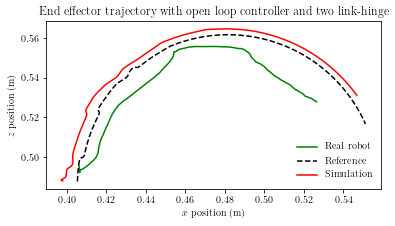

In [19]:
plt.figure(figsize=(6,4))

plt.plot(run_data['ee_pose']["act"]['x'][:-400],
         run_data['ee_pose']["act"]['z'][:-400], label="Real robot", color='g')
plt.plot(run_data['ee_pose']["des"]['x'][:-400],
         run_data['ee_pose']["des"]['z'][:-400], label="Reference", color='k', linestyle='--')
plt.plot(p_M[8000:250000,0].flatten(),
         p_M[8000:250000,2].flatten(), label="Simulation", color='red')
# plt.plot(x0s[1000:235000,3], x0s[1000:235000,5], label="Reference", color='k', linestyle='--')
    

plt.xlabel("$x$ position (m)")
plt.ylabel("$z$ position (m)")
plt.gca().set_aspect("equal")
plt.legend(frameon=False)
plt.title("End effector trajectory with open loop controller and two link-hinge")
plt.gcf().savefig("real_sim_comparison.pgf", backend="pgf")
plt.show()

In [16]:
len(run_data['ee_pose']["act"]['x'])

3000